#Microsoft Professional Program in Data Science Capstone Project 
##A notebook by C.Thinwa
###Challenge 1 Instructions
The challenges in this course are based on a real-world problem in which you must create a predictive machine learning model and enter it in a competition with your fellow students. Your first challenge is to explore the data and answer some basic questions about it. These questions will help you get started exploring the data, and your answers will be graded.

Your grade for this challenge accounts for 25% of your overall grade for the course.


###Challenge 2 Instructions
Now that you have  explored the training data, it's time to build a machine learning model and test it. You can use your tool of preference to generate and test your model.

To enter a submission for the competition, you must use your model to predict labels for the observations and then submit your results in the prescribed Submission format. Each time you submit an entry, it is scored using the test set to determine your place on the competition leaderboard. It is also scored using a private test set to which you do not have access in order to ensure your model is not over-fitted to the public test data. Your score is calculated based on an appropriate performance metric for the type of model you need to create, and this is translated into a grade for the challenge.

Your grade for this challenge accounts for 50% of your overall grade for the course.

## Data preprocessing

In [0]:
# We first import the necessary packages:
import numpy as np

import pandas as pd

from matplotlib import pyplot as plt

from sklearn import datasets, linear_model
from sklearn import metrics as met
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

!pip install researchpy
import researchpy as rp
from scipy import stats
from scipy.stats import chi2_contingency

import seaborn as sns 

import xgboost as xgb
from xgboost import XGBClassifier

In [0]:
# Then we load the data:
tr_f = pd.read_csv('https://raw.githubusercontent.com/CeeThinwa/DataScienceLearningDatasets/master/microsoft_capstone_train_values.csv')
tr_l = pd.read_csv('https://raw.githubusercontent.com/CeeThinwa/DataScienceLearningDatasets/master/microsoft_capstone_train_labels.csv')

###Initial Data Analysis

We kick off our analysis by calculating  summary statistics for our numerical variables. Results obtained from 500,000 observations were as shown below:

In [0]:
# Here numerical data is identified and stored separately for analysis
numericals = tr_f
numericals = numericals.drop(['co_applicant'], axis = 1)
numericals = numericals.drop(['property_type'], axis = 1)
numericals = numericals.drop(['loan_purpose'], axis = 1)
numericals = numericals.drop(['preapproval'], axis = 1)
numericals = numericals.drop(['loan_type'], axis = 1)
numericals = numericals.drop(['occupancy'], axis = 1)
numericals = numericals.drop(['applicant_ethnicity'], axis = 1)
numericals = numericals.drop(['applicant_race'], axis = 1)
numericals = numericals.drop(['applicant_sex'], axis = 1)
numericals = numericals.drop(['state_code'], axis = 1)
numericals = numericals.drop(['county_code'], axis = 1)
numericals = numericals.drop(['msa_md'], axis = 1)
numericals = numericals.drop(['lender'], axis = 1)

numericals.describe()

row_id  ...  number_of_1_to_4_family_units
count  500000.000000  ...                  477470.000000
mean   249999.500000  ...                    1886.147065
std    144337.711634  ...                     914.123744
min         0.000000  ...                       1.000000
25%    124999.750000  ...                    1301.000000
50%    249999.500000  ...                    1753.000000
75%    374999.250000  ...                    2309.000000
max    499999.000000  ...                   13623.000000

[8 rows x 9 columns]

Next, we examine the degree of skewness in the numerical data. Upon review of all numerical variables, there is considerable skewness in most of the variables as shown in the following histograms:

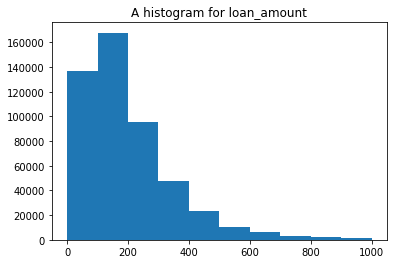

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


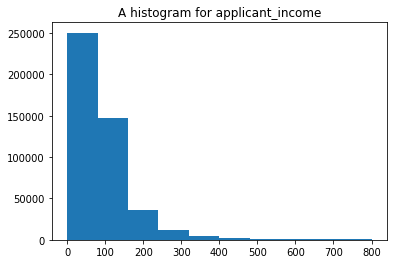

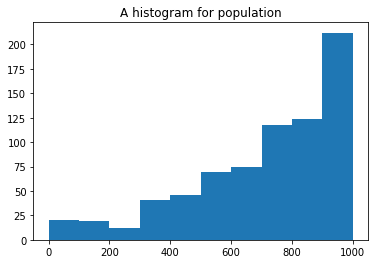

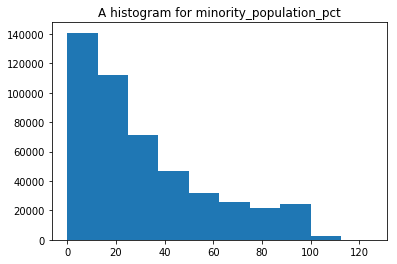

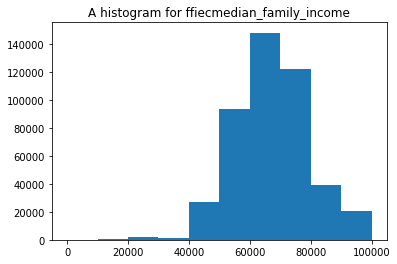

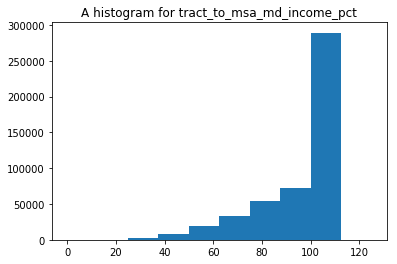

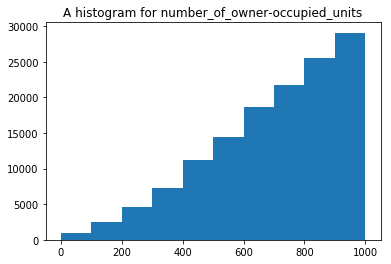

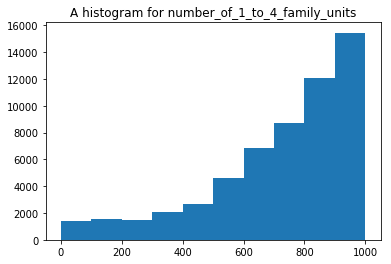

In [0]:
plt.title('A histogram for loan_amount')
plt.hist(tr_f.loan_amount, bins=None, range=(0,1000))
plt.show()
print('')

plt.title('A histogram for applicant_income')
plt.hist(tr_f.applicant_income, bins=None, range=(0,800))
plt.show()
print('')

plt.title('A histogram for population')
plt.hist(tr_f.population, bins=None, range=(0,1000))
plt.show()
print('')

plt.title('A histogram for minority_population_pct')
plt.hist(tr_f.minority_population_pct, bins=None, range=(0,125))
plt.show()
print('')

plt.title('A histogram for ffiecmedian_family_income')
plt.hist(tr_f.ffiecmedian_family_income, bins=None, range=(0,100000))
plt.show()
print('')

plt.title('A histogram for tract_to_msa_md_income_pct')
plt.hist(tr_f.tract_to_msa_md_income_pct, bins=None, range=(0,125))
plt.show()
print('')

plt.title('A histogram for number_of_owner-occupied_units')
plt.hist(tr_f['number_of_owner-occupied_units'], bins=None, range=(0,1000))
plt.show()
print('')

plt.title('A histogram for number_of_1_to_4_family_units')
plt.hist(tr_f.number_of_1_to_4_family_units, bins=None, range=(0,1000))
plt.show()

Finally, we draw a correlation matrix to find the strength of the relationships to the target.

[Text(0.5, 0, 'loan_amount'),
 Text(1.5, 0, 'applicant_income'),
 Text(2.5, 0, 'population'),
 Text(3.5, 0, 'minority_population_pct'),
 Text(4.5, 0, 'ffiecmedian_family_income'),
 Text(5.5, 0, 'tract_to_msa_md_income_pct'),
 Text(6.5, 0, 'number_of_owner-occupied_units'),
 Text(7.5, 0, 'number_of_1_to_4_family_units'),
 Text(8.5, 0, 'accepted')]

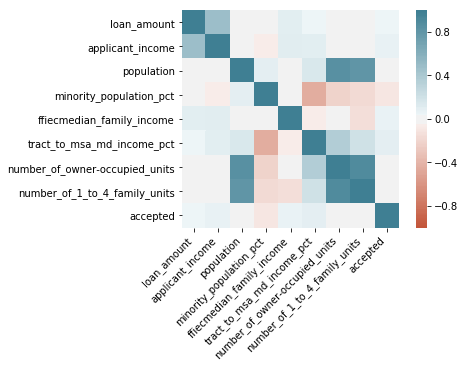

In [0]:
# To do this, we need to first join the label with the features:
numericals = numericals.join(tr_l, how='left', lsuffix='_caller', rsuffix='_other')
numericals = numericals.drop(['row_id_caller'], axis = 1)
numericals = numericals.drop(['row_id_other'], axis = 1)

# then plot the correlation matrix.
corr = numericals.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

Initial analysis for categorical variables involved an examining the frequencies of the various categories in the categorical variables contained in our data. Results obtained from 500,000 observations were as shown below:

In [0]:
# Frequency tables
cat1 = tr_f.groupby(['co_applicant'])['row_id'].count()
cat2 = tr_f.groupby(['property_type'])['row_id'].count()
cat3 = tr_f.groupby(['loan_purpose'])['row_id'].count()
cat4 = tr_f.groupby(['preapproval'])['row_id'].count()
cat5 = tr_f.groupby(['loan_type'])['row_id'].count()
cat6 = tr_f.groupby(['occupancy'])['row_id'].count()
cat7 = tr_f.groupby(['applicant_ethnicity'])['row_id'].count()
cat8 = tr_f.groupby(['applicant_race'])['row_id'].count()
cat9 = tr_f.groupby(['applicant_sex'])['row_id'].count()
cat10 = tr_f.groupby(['state_code'])['row_id'].count()
cat11 = tr_f.groupby(['county_code'])['row_id'].count()
cat12 = tr_f.groupby(['msa_md'])['row_id'].count()

print(cat1)
print(' ')
print(cat2)
print(' ')
print(cat3)
print(' ')
print(cat4)
print(' ')
print(cat5)
print(' ')
print(cat6)
print(' ')
print(cat7)
print(' ')
print(cat8)
print(' ')
print(cat9)
print(' ')
print(cat10)
print(' ')
print(cat11)
print(' ')
print(cat12)

co_applicant
False    299974
True     200026
Name: row_id, dtype: int64
 
property_type
1    478217
2     19741
3      2042
Name: row_id, dtype: int64
 
loan_purpose
1    209265
2     48065
3    242670
Name: row_id, dtype: int64
 
preapproval
1     28748
2     60143
3    411109
Name: row_id, dtype: int64
 
loan_type
1    370827
2     82430
3     39521
4      7222
Name: row_id, dtype: int64
 
occupancy
1    447394
2     50417
3      2189
Name: row_id, dtype: int64
 
applicant_ethnicity
1     50822
2    386061
3     57298
4      5819
Name: row_id, dtype: int64
 
applicant_race
1      4332
2     25756
3     40495
4      2339
5    361538
6     59862
7      5678
Name: row_id, dtype: int64
 
applicant_sex
1    315806
2    142876
3     35643
4      5675
Name: row_id, dtype: int64
 
state_code
-1     19132
 0      5230
 1      4716
 2     32509
 3     11648
 4     12858
 5      7614
 6     38712
 7      1016
 8      2089
 9     10923
 10    15732
 11     1128
 12     1579
 13      895
 14    1

Next, we conduct a Chi Square Test of Independence to see how the categorical features relate to the target, which is also a categorical output. Results are as follows:

In [0]:
# Define functions needed for analysis
def get_df_name(df, s):
  name =[x for x in globals() if globals()[x] is df][0]
  output1 = print('Post hoc test for ', name, ' and ', str(s.name))
  output2 = print('------------------------------------------------------------------------')
  return output1, output2

def post_hoc_test(df, s):
  get_df_name(df, s)
  for series in df:
    nl = "\n"
    crosstab = rp.crosstab(df[f"{series}"],s)
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    output1 = print(crosstab, nl)
    output2 = print(f"Chi2 value= {chi2}{nl}p-value= {round(p, 5)}{nl}Degrees of freedom= {dof}{nl}")
    output3 = print(' ')
  return output1, output2, output3

In [0]:
# Have the categorical variables ready for analysis
categoricals = tr_f
categoricals = categoricals.drop(['loan_amount'], axis = 1)
categoricals = categoricals.drop(['applicant_income'], axis = 1)
categoricals = categoricals.drop(['population'], axis = 1)
categoricals = categoricals.drop(['minority_population_pct'], axis = 1)
categoricals = categoricals.drop(['ffiecmedian_family_income'], axis = 1)
categoricals = categoricals.drop(['tract_to_msa_md_income_pct'], axis = 1)
categoricals = categoricals.drop(['number_of_owner-occupied_units'], axis = 1)
categoricals = categoricals.drop(['number_of_1_to_4_family_units'], axis = 1)
categoricals = categoricals.drop(['row_id'], axis = 1)

# Conduct Chi Square Test of Independence using earlier defined function.
post_hoc_test(categoricals , tr_l.accepted)

Post hoc test for  categoricals  and  accepted
------------------------------------------------------------------------
          accepted                
                 0       1     All
loan_type                         
1           186916  183911  370827
2            40792   41638   82430
3            19008   20513   39521
4             3170    4052    7222
All         249886  250114  500000 

Chi2 value= 197.95763447094782
p-value= 0.0
Degrees of freedom= 8

 
              accepted                
                     0       1     All
property_type                         
1               233960  244257  478217
2                15282    4459   19741
3                  644    1398    2042
All             249886  250114  500000 

Chi2 value= 6433.732382868869
p-value= 0.0
Degrees of freedom= 6

 
             accepted                
                    0       1     All
loan_purpose                         
1               84874  124391  209265
2               32243   15822   48

(None, None, None)

###Our First Data Split

In [0]:
#We split up the training dataset using scikitlearn
tr_l = tr_l.drop(['row_id'], axis = 1)

x_features, y_features, x_label, y_label = train_test_split(tr_f, tr_l, test_size=0.3)
print('We randomly split our training data in a 70:30 ratio to train the algorithm first')
print('before using the real test data:')
print(' ')
print('Our training features had a shape of ' + str(x_features.shape))
print('and our training label had a shape of '+ str(x_label.shape) + ';')
print('Our testing features had a shape of ' + str(y_features.shape))
print('and our testing label had a shape of '+ str(y_label.shape) + '.')

We randomly split our training data in a 70:30 ratio to train the algorithm first
before using the real test data:
 
Our training features had a shape of (350000, 22)
and our training label had a shape of (350000, 1);
Our testing features had a shape of (150000, 22)
and our testing label had a shape of (150000, 1).


####Cleaning Training Data

In [0]:
# First, we had to have an idea of how many null values were in the data:
print('How many null values were in each variable?')
print('The number of null values were as follows:')
Nulls = x_features.isnull().sum()
print(Nulls)
print(' ')

How many null values were in each variable?
The number of null values were as follows:
row_id                                0
loan_type                             0
property_type                         0
loan_purpose                          0
occupancy                             0
loan_amount                           0
preapproval                           0
msa_md                                0
state_code                            0
county_code                           0
applicant_ethnicity                   0
applicant_race                        0
applicant_sex                         0
applicant_income                  28051
population                        15778
minority_population_pct           15779
ffiecmedian_family_income         15762
tract_to_msa_md_income_pct        15816
number_of_owner-occupied_units    15850
number_of_1_to_4_family_units     15825
lender                                0
co_applicant                          0
dtype: int64
 


We treated null values in numerical data as shown below:

In [0]:
# We had to make them all zeros and then impute all 0s' with the median of the respective column
x_features = x_features.fillna(0)

x_features.applicant_income = x_features.applicant_income.replace([0],[x_features.applicant_income.median()])
x_features.population = x_features.population.replace([0],[x_features.population.median()])
x_features.minority_population_pct = x_features.minority_population_pct.replace([0],[x_features.minority_population_pct.median()])
x_features.tract_to_msa_md_income_pct = x_features.tract_to_msa_md_income_pct.replace([0],[x_features.tract_to_msa_md_income_pct.median()])
x_features.ffiecmedian_family_income = x_features.ffiecmedian_family_income.replace([0],[x_features.ffiecmedian_family_income.median()])
x_features.number_of_1_to_4_family_units = x_features.number_of_1_to_4_family_units.replace([0],[x_features.number_of_1_to_4_family_units.median()])
x_features['number_of_owner-occupied_units'] = x_features['number_of_owner-occupied_units'].replace([0],[x_features['number_of_owner-occupied_units'].median()])

In [0]:
# Then convert all numeric variables to logs
a = pd.Series(np.log(x_features['number_of_owner-occupied_units']))
b = pd.Series(np.log(x_features.number_of_1_to_4_family_units))
c = pd.Series(np.log(x_features.applicant_income))
d = pd.Series(np.log(x_features.population))
e = pd.Series(np.log(x_features.ffiecmedian_family_income))
f = pd.Series(np.log(x_features.tract_to_msa_md_income_pct))

logs_x = pd.DataFrame(np.log(x_features.loan_amount))
logs_x = logs_x.join(a)
logs_x = logs_x.join(b)
logs_x = logs_x.join(c)
logs_x = logs_x.join(d)
logs_x = logs_x.join(e)
logs_x = logs_x.join(f)

x_features = x_features.drop(['loan_amount'], axis = 1)
x_features = x_features.drop(['applicant_income'], axis = 1)
x_features = x_features.drop(['number_of_owner-occupied_units'], axis = 1)
x_features = x_features.drop(['number_of_1_to_4_family_units'], axis = 1)
x_features = x_features.drop(['population'], axis = 1)
x_features = x_features.drop(['ffiecmedian_family_income'], axis = 1)
x_features = x_features.drop(['tract_to_msa_md_income_pct'], axis = 1)

x_features = pd.concat([x_features, logs_x], axis = 1)

When we have 0s in any of our values, they affect the log transformation process negatively; directly imputing numerical missing values with the median of the respective column would have made us not deal with existing 0s in the data, so the best thing to do was convert all missing values to 0 first, then treat all the 0s in our data.

With numerical data sorted, categorical data was treated as follows:

In [0]:
# Create categorical dummy variables
applicant_ethnicity_dummies_x = pd.get_dummies(x_features.applicant_ethnicity, prefix='applicant_ethnicity_dummy')

applicant_race_dummies_x = pd.get_dummies(x_features.applicant_race, prefix='applicant_race_dummy')

applicant_sex_dummies_x = pd.get_dummies(x_features.applicant_sex, prefix='applicant_sex_dummy')

co_applicant_dummies_x = pd.get_dummies(x_features.co_applicant, prefix='co_applicant_dummy')

property_type_dummies_x = pd.get_dummies(x_features.property_type, prefix='property_type_dummy')

occupancy_dummies_x = pd.get_dummies(x_features.occupancy, prefix='occupancy_dummy')

loan_type_dummies_x = pd.get_dummies(x_features.loan_type, prefix='loan_type_dummy')

loan_purpose_dummies_x = pd.get_dummies(x_features.loan_purpose, prefix='loan_purpose_dummy')

preapproval_dummies_x = pd.get_dummies(x_features.preapproval, prefix='preapproval_dummy')

msa_md_dummies_x = pd.get_dummies(x_features.msa_md, prefix='msa_md_dummy')

county_code_dummies_x = pd.get_dummies(x_features.county_code, prefix='county_code_dummy')

state_code_dummies_x = pd.get_dummies(x_features.state_code, prefix='state_code_dummy')

In [0]:
# Replace original categorical variables with dummy variables
x_features = x_features.drop(['applicant_ethnicity'], axis = 1)
x_features = x_features.drop(['applicant_race'], axis = 1)
x_features = x_features.drop(['applicant_sex'], axis = 1)
x_features = x_features.drop(['loan_purpose'], axis = 1)
x_features = x_features.drop(['loan_type'], axis = 1)
x_features = x_features.drop(['occupancy'], axis = 1)
x_features = x_features.drop(['preapproval'], axis = 1)
x_features = x_features.drop(['property_type'], axis = 1)


x_features = x_features.join(applicant_ethnicity_dummies_x)
x_features = x_features.join(applicant_race_dummies_x)
x_features = x_features.join(applicant_sex_dummies_x)
x_features = x_features.join(loan_purpose_dummies_x)
x_features = x_features.join(loan_type_dummies_x)
x_features = x_features.join(occupancy_dummies_x)
x_features = x_features.join(preapproval_dummies_x)
x_features = x_features.join(property_type_dummies_x)

The reason why categorical variables were dummified is because even though the different categories were represented by numbers, model performance would improve if each category was represented in a binary way. Location variables were not dummified because they were too many - this would hinder computational efficiency and cause the model to overfit. The co_applicant variable was also not dummified because it was already a boolean.

In [0]:
# Finally, we keep only rows in x_label whose row_id matches the cleaned x_features
x_features = x_features.join(x_label, how='left', lsuffix='_caller', rsuffix='_other')

x_label = x_features.accepted

x_features = x_features.drop(['accepted'], axis = 1)

x_features = x_features.rename(index=str, columns={'row_id_caller':'row_id'})

print(x_label.shape)
print(x_features.shape)

(350000,)
(350000, 45)


In [0]:
x_features.head(5)

row_id  msa_md  ...  property_type_dummy_2  property_type_dummy_3
427710  427710     207  ...                      0                      0
189699  189699     350  ...                      0                      0
240020  240020     376  ...                      0                      0
76318    76318      16  ...                      0                      0
352257  352257      59  ...                      0                      0

[5 rows x 45 columns]

In [0]:
x_label.head(5)

427710    1
189699    1
240020    0
76318     0
352257    1
Name: accepted, dtype: int64

####Cleaning Testing Data

In this section, we repeat the cleaning process as described above. Training and testing data were cleaned separately to prevent cross-contamination of data.

In [0]:
y_features = y_features.fillna(0)

y_features.applicant_income = y_features.applicant_income.replace([0],[y_features.applicant_income.median()])
y_features.population = y_features.population.replace([0],[y_features.population.median()])
y_features.minority_population_pct = y_features.minority_population_pct.replace([0],[y_features.minority_population_pct.median()])
y_features.tract_to_msa_md_income_pct = y_features.tract_to_msa_md_income_pct.replace([0],[y_features.tract_to_msa_md_income_pct.median()])
y_features.ffiecmedian_family_income = y_features.ffiecmedian_family_income.replace([0],[y_features.ffiecmedian_family_income.median()])
y_features.number_of_1_to_4_family_units = y_features.number_of_1_to_4_family_units.replace([0],[y_features.number_of_1_to_4_family_units.median()])
y_features['number_of_owner-occupied_units'] = y_features['number_of_owner-occupied_units'].replace([0],[y_features['number_of_owner-occupied_units'].median()])

In [0]:
a = pd.Series(np.log(y_features['number_of_owner-occupied_units']))
b = pd.Series(np.log(y_features.number_of_1_to_4_family_units))
c = pd.Series(np.log(y_features.applicant_income))
d = pd.Series(np.log(y_features.population))
e = pd.Series(np.log(y_features.ffiecmedian_family_income))
f = pd.Series(np.log(y_features.tract_to_msa_md_income_pct))

logs_y = pd.DataFrame(np.log(y_features.loan_amount))
logs_y = logs_y.join(a)
logs_y = logs_y.join(b)
logs_y = logs_y.join(c)
logs_y = logs_y.join(d)
logs_y = logs_y.join(e)
logs_y = logs_y.join(f)

y_features = y_features.drop(['loan_amount'], axis = 1)
y_features = y_features.drop(['applicant_income'], axis = 1)
y_features = y_features.drop(['number_of_owner-occupied_units'], axis = 1)
y_features = y_features.drop(['number_of_1_to_4_family_units'], axis = 1)
y_features = y_features.drop(['population'], axis = 1)
y_features = y_features.drop(['ffiecmedian_family_income'], axis = 1)
y_features = y_features.drop(['tract_to_msa_md_income_pct'], axis = 1)

y_features = pd.concat([y_features, logs_y], axis = 1)

In [0]:
applicant_ethnicity_dummies_y = pd.get_dummies(y_features.applicant_ethnicity, prefix='applicant_ethnicity_dummy')

applicant_race_dummies_y = pd.get_dummies(y_features.applicant_race, prefix='applicant_race_dummy')

applicant_sex_dummies_y = pd.get_dummies(y_features.applicant_sex, prefix='applicant_sex_dummy')

co_applicant_dummies_y = pd.get_dummies(y_features.co_applicant, prefix='co_applicant_dummy')

property_type_dummies_y = pd.get_dummies(y_features.property_type, prefix='property_type_dummy')

occupancy_dummies_y = pd.get_dummies(y_features.occupancy, prefix='occupancy_dummy')

loan_type_dummies_y = pd.get_dummies(y_features.loan_type, prefix='loan_type_dummy')

loan_purpose_dummies_y = pd.get_dummies(y_features.loan_purpose, prefix='loan_purpose_dummy')

preapproval_dummies_y = pd.get_dummies(y_features.preapproval, prefix='preapproval_dummy')

msa_md_dummies_y = pd.get_dummies(y_features.msa_md, prefix='msa_md_dummy')

county_code_dummies_y = pd.get_dummies(y_features.county_code, prefix='county_code_dummy')

state_code_dummies_y = pd.get_dummies(y_features.state_code, prefix='state_code_dummy')

In [0]:
y_features = y_features.drop(['applicant_ethnicity'], axis = 1)
y_features = y_features.drop(['applicant_race'], axis = 1)
y_features = y_features.drop(['applicant_sex'], axis = 1)
y_features = y_features.drop(['loan_purpose'], axis = 1)
y_features = y_features.drop(['loan_type'], axis = 1)
y_features = y_features.drop(['occupancy'], axis = 1)
y_features = y_features.drop(['preapproval'], axis = 1)
y_features = y_features.drop(['property_type'], axis = 1)


y_features = y_features.join(applicant_ethnicity_dummies_y)
y_features = y_features.join(applicant_race_dummies_y)
y_features = y_features.join(applicant_sex_dummies_y)
y_features = y_features.join(loan_purpose_dummies_y)
y_features = y_features.join(loan_type_dummies_y)
y_features = y_features.join(occupancy_dummies_y)
y_features = y_features.join(preapproval_dummies_y)
y_features = y_features.join(property_type_dummies_y) 

In [0]:
y_features = y_features.join(y_label, how='left', lsuffix='_caller', rsuffix='_other')

y_label = y_features.accepted

y_features = y_features.drop(['accepted'], axis = 1)

y_features = y_features.rename(index=str, columns={'row_id_caller':'row_id'})

print(y_label.shape)
print(y_features.shape)

(150000,)
(150000, 45)


In [0]:
y_features.head(5)

row_id  msa_md  ...  property_type_dummy_2  property_type_dummy_3
385901  385901      45  ...                      0                      0
248032  248032      85  ...                      0                      0
391031  391031      -1  ...                      0                      0
498152  498152      74  ...                      0                      0
423558  423558      -1  ...                      0                      0

[5 rows x 45 columns]

In [0]:
y_label.head(5)

385901    1
248032    1
391031    0
498152    0
423558    0
Name: accepted, dtype: int64

####Data Scaling


At this stage, data was standardized so that the numerical log values, which were quite larger than the catregorical dummy values would not make the model attach more importance to them due to their size.

In [0]:
# At this stage, we can scale the cleaned data
scaler = StandardScaler()

custom_scaler = scaler.fit_transform(x_features)
x_features = pd.DataFrame(x_features)

custom_scaler = scaler.fit_transform(y_features)
y_features = pd.DataFrame(y_features)

y_features.head(5)

row_id  msa_md  ...  property_type_dummy_2  property_type_dummy_3
385901  385901      45  ...                      0                      0
248032  248032      85  ...                      0                      0
391031  391031      -1  ...                      0                      0
498152  498152      74  ...                      0                      0
423558  423558      -1  ...                      0                      0

[5 rows x 45 columns]

##Data modelling
At this stage, we have to refine and optimize our model to hit an accuracy of at least 71%.

In [0]:
# Here, I specified the tweaked parameters necessary for optimal performance of my classifier

# Modelling was done via the following loop:
# First I set the counter
i = 1 

# Next I defined a variable containing Stratified K-fold Cross validation with 10 as the number of folds
kf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)

# and performed cross-validation with the XGBClassifier algorithm.
for train_index, test_index in kf.split(x_features,x_label):
  
  print('\n{} of kfold {}'.format(i, kf.n_splits))
  
  xtr, xvl = x_features.iloc[train_index], x_features.iloc[test_index]
  ytr, yvl = x_label.iloc[train_index], x_label.iloc[test_index]
  
  model = XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=300, verbosity=1, silent=None, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1)
  model.fit(xtr, ytr, eval_set=[(xtr, ytr), (xvl, yvl)], eval_metric='error',verbose=False)
  
  y_predicted = model.predict(y_features)
  print('accuracy_score ', met.accuracy_score(y_label,y_predicted))
  
  i+=1


1 of kfold 10
accuracy_score  0.7169466666666666

2 of kfold 10
accuracy_score  0.71482

3 of kfold 10
accuracy_score  0.7161666666666666

4 of kfold 10
accuracy_score  0.71614

5 of kfold 10
accuracy_score  0.7161133333333334

6 of kfold 10
accuracy_score  0.7146533333333334

7 of kfold 10
accuracy_score  0.7164666666666667

8 of kfold 10
accuracy_score  0.7169066666666667

9 of kfold 10
accuracy_score  0.7155533333333334

10 of kfold 10
accuracy_score  0.7158333333333333


Text(0, 0.5, 'Feature Importance Score (F1 score)')

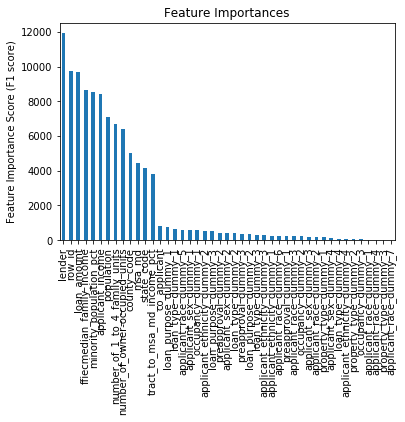

In [0]:
# Once the model ran, it was evaluated and feature importance was investigated:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score (F1 score)')

##Model validation

With model training complete, the same preprocessing steps were applied onto the validation data that would be uploaded onto the platform for scoring.

In [0]:
# First we load the actual test data
v_features = pd.read_csv('https://raw.githubusercontent.com/CeeThinwa/DataScienceLearningDatasets/master/microsoft_capstone_test_values.csv')

In [0]:
v_features = v_features.fillna(0)

v_features.applicant_income = v_features.applicant_income.replace([0],[v_features.applicant_income.median()])
v_features.population = v_features.population.replace([0],[v_features.population.median()])
v_features.minority_population_pct = v_features.minority_population_pct.replace([0],[v_features.minority_population_pct.median()])
v_features.tract_to_msa_md_income_pct = v_features.tract_to_msa_md_income_pct.replace([0],[v_features.tract_to_msa_md_income_pct.median()])
v_features.ffiecmedian_family_income = v_features.ffiecmedian_family_income.replace([0],[v_features.ffiecmedian_family_income.median()])
v_features.number_of_1_to_4_family_units = v_features.number_of_1_to_4_family_units.replace([0],[v_features.number_of_1_to_4_family_units.median()])
v_features['number_of_owner-occupied_units'] = v_features['number_of_owner-occupied_units'].replace([0],[v_features['number_of_owner-occupied_units'].median()])

In [0]:
a = pd.Series(np.log(v_features['number_of_owner-occupied_units']))
b = pd.Series(np.log(v_features.number_of_1_to_4_family_units))
c = pd.Series(np.log(v_features.applicant_income))
d = pd.Series(np.log(v_features.population))
e = pd.Series(np.log(v_features.ffiecmedian_family_income))
f = pd.Series(np.log(v_features.tract_to_msa_md_income_pct))


logs_v = pd.DataFrame(np.log(v_features.loan_amount))
logs_v = logs_v.join(a)
logs_v = logs_v.join(b)
logs_v = logs_v.join(c)
logs_v = logs_v.join(d)
logs_v = logs_v.join(e)
logs_v = logs_v.join(f)


v_features = v_features.drop(['loan_amount'], axis = 1)
v_features = v_features.drop(['applicant_income'], axis = 1)
v_features = v_features.drop(['number_of_owner-occupied_units'], axis = 1)
v_features = v_features.drop(['number_of_1_to_4_family_units'], axis = 1)
v_features = v_features.drop(['population'], axis = 1)
v_features = v_features.drop(['ffiecmedian_family_income'], axis = 1)
v_features = v_features.drop(['tract_to_msa_md_income_pct'], axis = 1) 

v_features = pd.concat([v_features, logs_v], axis = 1)

In [0]:
applicant_ethnicity_dummies_v = pd.get_dummies(v_features.applicant_ethnicity, prefix='applicant_ethnicity_dummy')

applicant_race_dummies_v = pd.get_dummies(v_features.applicant_race, prefix='applicant_race_dummy')

applicant_sex_dummies_v = pd.get_dummies(v_features.applicant_sex, prefix='applicant_sex_dummy')

co_applicant_dummies_v = pd.get_dummies(v_features.co_applicant, prefix='co_applicant_dummy')

property_type_dummies_v = pd.get_dummies(v_features.property_type, prefix='property_type_dummy')

occupancy_dummies_v = pd.get_dummies(v_features.occupancy, prefix='occupancy_dummy')

loan_type_dummies_v = pd.get_dummies(v_features.loan_type, prefix='loan_type_dummy')

loan_purpose_dummies_v = pd.get_dummies(v_features.loan_purpose, prefix='loan_purpose_dummy')

preapproval_dummies_v = pd.get_dummies(v_features.preapproval, prefix='preapproval_dummy')

msa_md_dummies_v = pd.get_dummies(v_features.msa_md, prefix='msa_md_dummy')

county_code_dummies_v = pd.get_dummies(v_features.county_code, prefix='county_code_dummy')

state_code_dummies_v = pd.get_dummies(v_features.state_code, prefix='state_code_dummy')

In [0]:
v_features = v_features.drop(['applicant_ethnicity'], axis = 1)
v_features = v_features.drop(['applicant_race'], axis = 1)
v_features = v_features.drop(['applicant_sex'], axis = 1)
v_features = v_features.drop(['loan_purpose'], axis = 1)
v_features = v_features.drop(['loan_type'], axis = 1)
v_features = v_features.drop(['occupancy'], axis = 1)
v_features = v_features.drop(['preapproval'], axis = 1)
v_features = v_features.drop(['property_type'], axis = 1)


v_features = v_features.join(applicant_ethnicity_dummies_v)
v_features = v_features.join(applicant_race_dummies_v)
v_features = v_features.join(applicant_sex_dummies_v)

v_features = v_features.join(loan_purpose_dummies_v)
v_features = v_features.join(loan_type_dummies_v)

v_features = v_features.join(occupancy_dummies_v)
v_features = v_features.join(preapproval_dummies_v)
v_features = v_features.join(property_type_dummies_v)

Once preprocessing was completed, modelling was conducted, with the predicted answer downloaded as a .csv file for submission onto the platform.

In [0]:
v_predict = model.predict(v_features)

Answer = pd.DataFrame(v_predict)

print(Answer.shape)
Answer.head(10)

(500000, 1)


0
0  1
1  1
2  0
3  1
4  0
5  1
6  0
7  0
8  1
9  1

In [35]:
# And save and download the prediction
from IPython.display import HTML
import base64  
import pandas as pd  

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index =True)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(Answer)